In [51]:
import json
import os
import numpy as np
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
import seaborn as sns
from numpy import array

import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [151]:
def make_binary(row):
    label =  row['label']
    
    if label == 'food':
        return 1
    else:
        return 0
    
# Read in the json file as a python dict using photo_id as key
def create_mapping(path):
    yelp_data = {}
    with open(path) as file:
        for line in file:
            cur_img = json.loads(line)
            yelp_data[cur_img['photo_id']] = cur_img
            
    # Convert yelp_data into dataframe
    df = pd.DataFrame.from_dict(yelp_data, 'index')

    # Add binary label for 'food' vs 'not food'
    df['is_food'] = df.apply(make_binary, axis = 1)
    
    return df, yelp_data

# ratio is a list of three integers that sum to 100. e.g. [60,20,20]
def split_train_dev_test(df, ratio):
    
    data_size = len(df)
    train_split = int((ratio[0] / float(100)) * data_size)
    dev_split = int(((ratio[0] + ratio[1])  / float(100)) * data_size)
    
    train = df[:train_split]
    dev = df[train_split:dev_split]
    test = df[dev_split:]
    
    df['data'] = ''
    df['data'][:train_split] = 'train'
    df['data'][train_split:dev_split] = 'dev'
    df['data'][dev_split:] = 'test'
    
    
    return train, dev, test
    

In [152]:
# Convert images into a list of numpy arrays, and a list of integers
def read_image(all_photo_name, path, label, df, binary = True):
    
    
    np_labels = []
    np_imgs = []

    start_time = time.time()
    
    
    for idx, p in enumerate(all_photo_name):
        
        if (idx % 1000 == 0):
            print('number of photos processed:', idx)
            time_elapsed = time.time() - start_time
            print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
        
        if (p != '.DS_Store'):
            data = plt.imread(path + p + '.jpg')
            image_resized = resize(data, (128, 128))
            image_reshaped = image_resized.transpose()
            np_imgs.append(image_reshaped)
            p_id = p
            
            if label == 'stars':
                star = df[df['photo_id'] == p_id]['stars'].values
            
                
                if star > 4:
                    np_labels.append(2)                
                elif star < 3.5:
                    np_labels.append(0)
                else:
                    np_labels.append(1)
                    
            if label == 'type':
                rest_type = df[df['photo_id'] == p_id]['type'].values
            
                np_labels.append(rest_type)
                
                
            else:
                if yelp_data[p_id]['label'] == 'food':          
                    np_labels.append(1)

                else:
                    if binary:
                        np_labels.append(0)
                    else:            
                        if yelp_data[p_id]['label'] == 'drink':
                            np_labels.append(0)
                        elif yelp_data[p_id]['label'] == 'inside':
                            np_labels.append(2)
                        elif yelp_data[p_id]['label'] == 'outside':
                            np_labels.append(3)
                        else:
                            np_labels.append(4)

    imgs_npy = np.asarray(np_imgs)
    label_npy = np.asarray(np_labels)
    
    
    print('finished!')
    time_elapsed = time.time() - start_time
    print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
    
    return imgs_npy, label_npy

In [153]:
class Dataset(Dataset):
    def __init__(self, imgs_npy, label_npy, train=True, normalize=False):
        """
        """
        X = imgs_npy.astype(float)
        y = label_npy.astype(float)  
        print(X.shape)
        if normalize:
            for index, img in enumerate(X):
                img_mean = img.mean()
                img_std = img.std()
                img = (img - img_mean) / img_std
                X[index] = img
            
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).float()

    def __len__(self):
        
        return self.len

    def __getitem__(self, idx):
        
        return self.x_data[idx], self.y_data[idx]

In [181]:
df, yelp_data = create_mapping('photos.json')

In [182]:
#Preprocessing

print('len before processing:', len(df))
stars = pd.read_pickle('stars.pickle')
df = df[df['label'] == 'food']
df = pd.merge(left=df, right=stars, how='left', on='business_id')

df = df[~df['type'].isnull()]

# bad = df['stars'] < 3.5
# good = df['stars'] > 4
# df = df[bad | good]

# df = df[~df['stars'].isnull()]

print('len after processing:', len(df))

len before processing: 206949
len after processing: 57551


In [183]:
train, dev, test = split_train_dev_test(df, [60, 20, 20])

/Users/ydkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ydkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ydkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [185]:
# Get all the file names of photos
train_photos = train['photo_id'].tolist()[:3000]
test_photos = dev['photo_id'].tolist()[:1000]

In [184]:
df.pivot_table(values='business_id', index='type', columns='data', aggfunc=len, margins=True)

data,dev,test,train,All
type,,,,
1.0,5325,5333,16147,26805
2.0,2342,2339,6781,11462
3.0,2170,2167,6495,10832
4.0,1673,1672,5107,8452
All,11510,11511,34530,57551


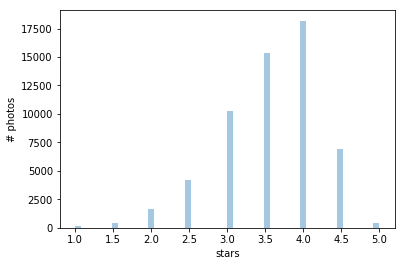

In [186]:
sns.distplot(df['stars'], kde=False)
plt.ylabel('# photos')
plt.show()

## 1. Test on binary data

In [85]:
train_imgs_npy, train_label_npy = read_image(train_photos, 'photos/')
test_imgs_npy, test_label_npy = read_image(test_photos, 'photos/')

# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

(3000, 3, 128, 128)
(1000, 3, 128, 128)


/Users/ydkim/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


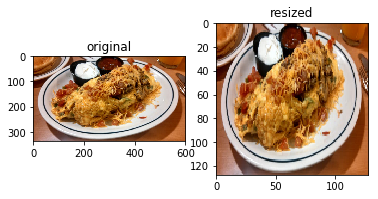

In [108]:
# Plot the resized first image in dataset

sample_photo = train_photos[3]

f, ax = plt.subplots(1,2)

test_data = plt.imread('photos/' + sample_photo + '.jpg')
resized_data = resize(test_data, (128, 128))

ax[0].imshow(test_data)
ax[0].set_title('original')

ax[1].imshow(resized_data)
ax[1].set_title('resized')

plt.show()

In [109]:
# # Visualize the dataset
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title('Visualize the dataset')
    plt.imshow(np.transpose(npimg))
#     plt.imshow(np.transpose(npimg, (1, 2, 0))/255)
    

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# plt.imshow(resized_data)

plt.show()


IndexError: index 2284 is out of range for dimension 0 (of size 1176)

In [31]:
# # Visualize the dataset
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title('Visualize the dataset')
    plt.imshow(np.transpose(npimg))
#     plt.imshow(np.transpose(npimg, (1, 2, 0))/255)
    

# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# plt.imshow(resized_data)


In [110]:
# Simple neural network
class Net(nn.Module):
    def __init__(self, binary=True):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128*128*3, 1024)
        if binary:
            self.fc2 = nn.Linear(1024, 2)
        else: 
            self.fc2 = nn.Linear(1024, 5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = F.sigmoid(self.fc1(x))
        out = F.sigmoid(self.fc2(out))
        
        return out

In [195]:
train_label_npy.astype

array([[ 3.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 3.]])

In [140]:
def train_accuracy(net):
    
    start_time = time.time()

    # Specify the loss function
    criterion = nn.CrossEntropyLoss()

    # Specify the optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

    max_epochs = 10

    # loss_np = np.zeros((max_epochs))
    accuracy = np.zeros((max_epochs))

    for epoch in range(max_epochs):
        print('epoch:', epoch)
        time_elapsed = time.time() - start_time
        print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
 
        tot_correct = 0
        tot_len = 0
        for i, data in enumerate(train_loader, 0):
            
            
            # Get inputs and labels from data loader 
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels).long()

            # Feed the input data into the network 
            y_pred = net(inputs)

            # Calculate the loss using predicted labels and ground truth labels
            loss = criterion(y_pred, labels)

            # zero gradient
            optimizer.zero_grad()

            # backpropogates to compute gradient
            loss.backward()

            # updates the weghts
            optimizer.step()

            # convert predicted laels into numpy
            y_pred_np = y_pred.data.numpy()

            # calculate the training accuracy of the current model
            pred_np = np.argmax(y_pred_np, axis=1)
            label_np = labels.data.numpy().reshape(len(labels),1)

            pred_np = pred_np.reshape(len(pred_np), 1)

            correct=0
            for j in range(y_pred_np.shape[0]):
                if pred_np[j,:] == label_np[j,:]:
                    correct += 1

            tot_len+=1
            tot_correct+= float(correct)/float(len(label_np))
#             tot_loss+= loss.data.numpy()

        accuracy[epoch] = float(tot_correct)/float(tot_len)
#         loss_np[epoch] = tot_loss / tot_len
        print('epoch {} accuracy: {:5.2f}'.format(epoch, accuracy[epoch]))


    print("final training accuracy: ", accuracy[max_epochs-1])

    epoch_number = np.arange(0,max_epochs,1)

    # Plot the training accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, accuracy)
    plt.title('training accuracy over epoches')
    plt.xlabel('Number of Epoch')
    plt.ylabel('accuracy')
    plt.show()


In [112]:
def test_accuracy(net):
    start_time = time.time()
    
    tot_correct = 0
    tot_len = 0
    
    pred_labels = []
    true_labels = []
    
    for i, test_data in enumerate(test_loader, 0):
        # Get inputs and labels from data loader 
        inputs, labels = test_data
        inputs, labels = Variable(inputs), Variable(labels).long()

        # Feed the input data into the network 
        y_pred = net(inputs)

        y_pred_np = y_pred.data.numpy()
        
        # calculate the training accuracy of the current model
        pred_np = np.argmax(y_pred_np, axis=1)
        label_np = labels.data.numpy().reshape(len(labels),1)

        pred_np = pred_np.reshape(len(pred_np), 1)

        correct=0
        
        pred_labels.append(pred_np)
        true_labels.append(label_np)
#         print(pred_np)
#         print(label_np)
        
        for j in range(y_pred_np.shape[0]):
            if pred_np[j,:] == label_np[j,:]:
                correct += 1

        tot_len+=1
        tot_correct+= float(correct)/float(len(label_np))
#         tot_loss+= loss.data.numpy()

    test_accuracy = float(tot_correct)/float(tot_len)
    print('test accuracy:{:5.2f}'.format(test_accuracy))
    
    time_elapsed = time.time() - start_time
    print('time elapsed:{:5.2f} seconds'.format(time_elapsed))
    
    
    return pred_labels, true_labels, test_accuracy

epoch: 0
time elapsed: 0.00 seconds
epoch: 1
time elapsed:12.41 seconds
epoch: 2
time elapsed:24.36 seconds
epoch: 3
time elapsed:39.12 seconds
epoch: 4
time elapsed:53.26 seconds
epoch: 5
time elapsed:69.14 seconds
epoch: 6
time elapsed:86.10 seconds
epoch: 7
time elapsed:102.65 seconds
epoch: 8
time elapsed:117.36 seconds
epoch: 9
time elapsed:130.21 seconds
epoch: 10
time elapsed:144.65 seconds
epoch: 11
time elapsed:165.51 seconds
epoch: 12
time elapsed:184.36 seconds
epoch: 13
time elapsed:203.85 seconds
epoch: 14
time elapsed:220.34 seconds
epoch: 15
time elapsed:234.13 seconds
epoch: 16
time elapsed:246.87 seconds
epoch: 17
time elapsed:258.91 seconds
epoch: 18
time elapsed:271.98 seconds
epoch: 19
time elapsed:286.77 seconds
final training accuracy:  0.8527250744047619


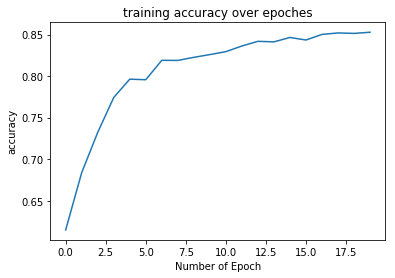

In [89]:
net = Net(True)
train_accuracy(net)

In [90]:
test_acc = test_accuracy(net)

(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(104, 2)
test accuracy: 0.84
time elapsed: 1.45 seconds


## 2. Test on multinomial data

In [34]:
train_imgs_npy, train_label_npy = read_image(train_photos, 'photos/', label = 'is_food', binary=False)
test_imgs_npy, test_label_npy = read_image(test_photos, 'photos/', label = 'is_food', binary=False)

# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

number of photos processed: 0
time elapsed: 0.00 seconds


/Users/ydkim/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

epoch: 0
time elapsed: 0.00 seconds
epoch: 1
time elapsed:13.16 seconds
epoch: 2
time elapsed:24.93 seconds
epoch: 3
time elapsed:36.23 seconds
epoch: 4
time elapsed:47.83 seconds
epoch: 5
time elapsed:59.34 seconds
epoch: 6
time elapsed:71.03 seconds
epoch: 7
time elapsed:82.86 seconds
epoch: 8
time elapsed:95.47 seconds
epoch: 9
time elapsed:110.73 seconds
epoch: 10
time elapsed:126.48 seconds
epoch: 11
time elapsed:140.36 seconds
epoch: 12
time elapsed:153.23 seconds
epoch: 13
time elapsed:166.65 seconds
epoch: 14
time elapsed:179.53 seconds
epoch: 15
time elapsed:191.07 seconds
epoch: 16
time elapsed:202.57 seconds
epoch: 17
time elapsed:215.56 seconds
epoch: 18
time elapsed:228.25 seconds
epoch: 19
time elapsed:239.90 seconds
final training accuracy:  0.6356026785714286


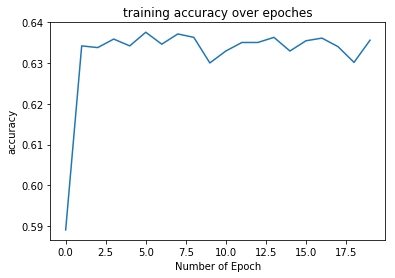

In [94]:
net_multi = Net(False)
train_accuracy(net_multi)

In [95]:
test_acc = test_accuracy(net_multi)

(128, 5)
(128, 5)
(128, 5)
(128, 5)
(128, 5)
(128, 5)
(128, 5)
(104, 5)
test accuracy: 0.63
time elapsed: 1.24 seconds


## 3. Tuning parameters in CNN 

In [191]:
# CNN
class CNet(nn.Module):
    def __init__(self, binary=True):
        super(CNet, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 0)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 0)
        self.fc1 = nn.Linear(16*58*58, 1024)
        if binary:
            self.fc2 = nn.Linear(1024, 2)
        else:
            self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.sigmoid(self.fc2(out))
        
        return out

epoch: 0
time elapsed: 0.00 seconds
epoch: 1
time elapsed:50.20 seconds
epoch: 2
time elapsed:90.75 seconds
epoch: 3
time elapsed:131.52 seconds
epoch: 4
time elapsed:171.68 seconds
epoch: 5
time elapsed:211.96 seconds
epoch: 6
time elapsed:252.59 seconds
epoch: 7
time elapsed:293.49 seconds
epoch: 8
time elapsed:334.42 seconds
epoch: 9
time elapsed:375.96 seconds
epoch: 10
time elapsed:417.12 seconds
epoch: 11
time elapsed:457.88 seconds
epoch: 12
time elapsed:498.44 seconds
epoch: 13
time elapsed:539.59 seconds
epoch: 14
time elapsed:580.94 seconds
epoch: 15
time elapsed:620.71 seconds
epoch: 16
time elapsed:660.57 seconds
epoch: 17
time elapsed:700.64 seconds
epoch: 18
time elapsed:741.11 seconds
epoch: 19
time elapsed:781.44 seconds
final training accuracy:  0.6741071428571428


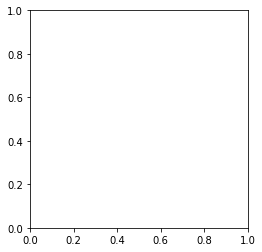

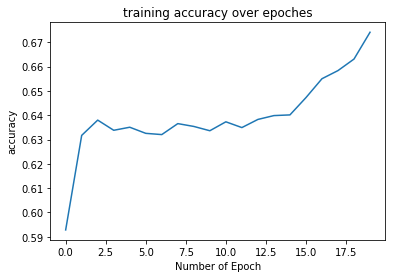

In [104]:
cnet = CNet(False)
train_accuracy(cnet)

In [98]:
test_acc = test_accuracy(cnet)

(128, 5)
(128, 5)
(128, 5)
(128, 5)
(128, 5)
(128, 5)
(128, 5)
(104, 5)
test accuracy: 0.67
time elapsed: 7.86 seconds


## 3. Predicting stars

In [175]:
train_imgs_npy, train_label_npy = read_image(train_photos, 'photos/', 'stars', df, binary=False)
test_imgs_npy, test_label_npy = read_image(test_photos, 'photos/', 'stars', df, binary=False)

number of photos processed: 0
time elapsed: 0.00 seconds


/Users/ydkim/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


number of photos processed: 1000
time elapsed:19.61 seconds
number of photos processed: 2000
time elapsed:38.89 seconds
finished!
time elapsed:58.80 seconds
number of photos processed: 0
time elapsed: 0.00 seconds
finished!
time elapsed:19.07 seconds


In [176]:
# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

(3000, 3, 128, 128)
(1000, 3, 128, 128)


In [177]:
len(train_label_npy)

6000

In [180]:
cnet = CNet(False)
train_accuracy(cnet)

epoch: 0
time elapsed: 0.00 seconds


KeyboardInterrupt: 

In [ ]:
test_acc = test_accuracy(cnet)

## 4. Predicting restaurant categories

In [187]:
train_imgs_npy, train_label_npy = read_image(train_photos, 'photos/', 'type', df, binary=False)
test_imgs_npy, test_label_npy = read_image(test_photos, 'photos/', 'type', df, binary=False)

number of photos processed: 0
time elapsed: 0.00 seconds


/Users/ydkim/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


number of photos processed: 1000
time elapsed:20.87 seconds
number of photos processed: 2000
time elapsed:41.58 seconds
finished!
time elapsed:64.46 seconds
number of photos processed: 0
time elapsed: 0.00 seconds
finished!
time elapsed:21.24 seconds


In [188]:
# Specify the training dataset
train_dataset = Dataset(train_imgs_npy, train_label_npy.astype(int))
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)

# Specify the test dataset
test_dataset = Dataset(test_imgs_npy, test_label_npy.astype(int))
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True)

(3000, 3, 128, 128)
(1000, 3, 128, 128)


In [192]:
cnet = CNet(False)
train_accuracy(cnet)

epoch: 0
time elapsed: 0.00 seconds


RuntimeError: multi-target not supported at /Users/soumith/minicondabuild3/conda-bld/pytorch_1518385717421/work/torch/lib/THNN/generic/ClassNLLCriterion.c:22

In [ ]:
test_acc = test_accuracy(cnet)